In [1]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [2]:
# import the packages
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# prepare NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
# Import Dataset
meta_data = pd.read_csv('clean_meta_data_5000.csv')
meta_data.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,No Information Available,No Information Available,No Information Available,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,No Information Available
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,No Information Available,No Information Available,No Information Available,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,No Information Available
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,No Information Available,No Information Available,No Information Available,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,No Information Available
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,No Information Available,No Information Available,No Information Available,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,No Information Available
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,No Information Available,No Information Available,No Information Available,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,No Information Available


In [5]:
sub_abstract = meta_data[["abstract"]]
sub_abstract.head()

,abstract
0,OBJECTIVE: This retrospective chart review des...
1,Inflammatory diseases of the respiratory tract...
2,Surfactant protein-D (SP-D) participates in th...
3,Endothelin-1 (ET-1) is a 21 amino acid peptide...
4,Respiratory syncytial virus (RSV) and pneumoni...


In [6]:
data = sub_abstract.abstract.values.tolist()
# remove useless items
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]
pprint(data[:1])


['OBJECTIVE: This retrospective chart review describes the epidemiology and '
 'clinical features of 40 patients with culture-proven Mycoplasma pneumoniae '
 'infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. '
 'METHODS: Patients with positive M. pneumoniae cultures from respiratory '
 'specimens from January 1997 through December 1998 were identified through '
 'the Microbiology records. Charts of patients were reviewed. RESULTS: 40 '
 'patients were identified, 33 (82.5%) of whom required admission. Most '
 'infections (92.5%) were community-acquired. The infection affected all age '
 'groups but was most common in infants (32.5%) and pre-school children '
 '(22.5%). It occurred year-round but was most common in the fall (35%) and '
 'spring (30%). More than three-quarters of patients (77.5%) had '
 'comorbidities. Twenty-four isolates (60%) were associated with pneumonia, 14 '
 '(35%) with upper respiratory tract infections, and 2 (5%) with '
 'bronchiolitis. 

In [7]:
# Tokenize words and Clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['objective', 'this', 'retrospective', 'chart', 'review', 'describes', 'the', 'epidemiology', 'and', 'clinical', 'features', 'of', 'patients', 'with', 'culture', 'proven', 'mycoplasma', 'pneumoniae', 'infections', 'at', 'king', 'abdulaziz', 'university', 'hospital', 'jeddah', 'saudi', 'arabia', 'methods', 'patients', 'with', 'positive', 'pneumoniae', 'cultures', 'from', 'respiratory', 'specimens', 'from', 'january', 'through', 'december', 'were', 'identified', 'through', 'the', 'microbiology', 'records', 'charts', 'of', 'patients', 'were', 'reviewed', 'results', 'patients', 'were', 'identified', 'of', 'whom', 'required', 'admission', 'most', 'infections', 'were', 'community', 'acquired', 'the', 'infection', 'affected', 'all', 'age', 'groups', 'but', 'was', 'most', 'common', 'in', 'infants', 'and', 'pre', 'school', 'children', 'it', 'occurred', 'year', 'round', 'but', 'was', 'most', 'common', 'in', 'the', 'fall', 'and', 'spring', 'more', 'than', 'three', 'quarters', 'of', 'patients', '

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['objective', 'this', 'retrospective', 'chart_review', 'describes', 'the', 'epidemiology', 'and', 'clinical', 'features', 'of', 'patients', 'with', 'culture', 'proven', 'mycoplasma_pneumoniae', 'infections', 'at', 'king', 'abdulaziz', 'university_hospital', 'jeddah', 'saudi_arabia', 'methods', 'patients', 'with', 'positive', 'pneumoniae', 'cultures', 'from', 'respiratory', 'specimens', 'from', 'january', 'through', 'december', 'were', 'identified', 'through', 'the', 'microbiology', 'records', 'charts', 'of', 'patients', 'were', 'reviewed', 'results', 'patients', 'were', 'identified', 'of', 'whom', 'required', 'admission', 'most', 'infections', 'were', 'community_acquired', 'the', 'infection', 'affected', 'all', 'age', 'groups', 'but', 'was', 'most', 'common', 'in', 'infants', 'and', 'pre', 'school', 'children', 'it', 'occurred', 'year', 'round', 'but', 'was', 'most', 'common', 'in', 'the', 'fall', 'and', 'spring', 'more', 'than', 'three', 'quarters', 'of', 'patients', 'had', 'comorbidi

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['describe', 'epidemiology', 'clinical', 'feature', 'patient', 'culture', 'prove', 'infection', 'method', 'patient', 'positive', 'pneumoniae', 'culture', 'respiratory', 'specimen', 'identify', 'microbiology', 'record', 'chart', 'patient', 'review', 'result', 'patient', 'identify', 'required', 'admission', 'infection', 'community_acquired', 'infection', 'affect', 'age', 'group', 'common', 'infant', 'pre', 'school', 'child', 'occur', 'year', 'common', 'fall', 'spring', 'quarter', 'patient', 'comorbiditie', 'isolate', 'associate', 'pneumonia', 'tract', 'infection', 'bronchiolitis', 'cough', 'fever', 'malaise', 'common', 'symptom', 'crepitation', 'wheeze', 'common', 'sign', 'patient', 'pneumonia', 'crepitation', 'bronchial', 'breathing', 'patient', 'likely', 'non', 'patient', 'present', 'pneumonia', 'patient', 'uneventful', 'recovery', 'recover', 'follow', 'complication', 'die', 'pneumoniae', 'infection', 'die', 'due', 'underlie', 'comorbiditie', 'patient', 'die', 'pneumoniae', 'pneumonia

In [11]:
# Create the Dictionary and Corpus needed for Topic Modeling
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 5), (11, 1), (12, 4), (13, 1), (14, 1), (15, 1), (16, 2), (17, 2), (18, 1), (19, 1), (20, 3), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 2), (32, 6), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 11), (42, 5), (43, 3), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1)]]


In [12]:
# pass the id as a key to the dictionary to see what word a given id corresponds to.
id2word[1]

'affect'

In [13]:
# corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('admission', 1),
  ('affect', 1),
  ('age', 1),
  ('associate', 1),
  ('breathing', 1),
  ('bronchial', 1),
  ('bronchiolitis', 1),
  ('chart', 1),
  ('child', 2),
  ('clinical', 1),
  ('common', 5),
  ('community_acquired', 1),
  ('comorbiditie', 4),
  ('complication', 1),
  ('conclusion', 1),
  ('cough', 1),
  ('crepitation', 2),
  ('culture', 2),
  ('datum', 1),
  ('describe', 1),
  ('die', 3),
  ('due', 1),
  ('epidemiology', 1),
  ('fall', 1),
  ('feature', 1),
  ('fever', 1),
  ('find', 1),
  ('follow', 1),
  ('group', 1),
  ('high', 1),
  ('identify', 2),
  ('infant', 2),
  ('infection', 6),
  ('isolate', 1),
  ('likely', 1),
  ('malaise', 1),
  ('method', 1),
  ('microbiology', 1),
  ('mortality', 1),
  ('non', 1),
  ('occur', 1),
  ('patient', 11),
  ('pneumonia', 5),
  ('pneumoniae', 3),
  ('positive', 1),
  ('pre', 1),
  ('preschool', 1),
  ('present', 1),
  ('prove', 1),
  ('publish', 1),
  ('quarter', 1),
  ('rate', 1),
  ('record', 1),
  ('recover', 1),
  ('recovery', 

In [14]:
# Build LDA model with different num_topics
lda_model_2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
lda_model_10 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
lda_model_20 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
lda_model_40 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [18]:
lda_model_80 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=80, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
lda_model_120 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=120, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [20]:
lda_model_150 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=150, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [21]:
lda_model_180 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=180, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [22]:
lda_model_200 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=200, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [29]:
# calculate coherence_vals with Different num_topics
lda_model_list = [lda_model_2, lda_model_10, lda_model_20, lda_model_40, lda_model_80, lda_model_120, lda_model_150, lda_model_180, lda_model_200]

coherence_vals = []
for lda_model in lda_model_list:
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_vals.append(coherence_lda)


num_topics = [2,10,20,40,80,120,150,180,200]
vals_diff_topics = {'num_topics':num_topics, 'coherence_vals':coherence_vals}
vals_diff_topics_df = pd.DataFrame(vals_diff_topics)
print(vals_diff_topics_df)


   num_topics  coherence_vals
0           2        0.402655
1          10        0.432534
2          20        0.494512
3          40        0.399467
4          80        0.400447
5         120        0.368009
6         150        0.372489
7         180        0.366634
8         200        0.356407


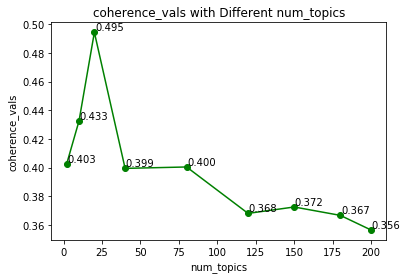

In [49]:
# plot coherence_vals with Different num_topics
xs = np.array(num_topics)
ys = np.array(coherence_vals)
plt.plot(xs, ys, 'go-')  # 'bo-' means blue color, round points, (solid lines)
for x, y in zip(xs, ys):
    label = "{:.3f}".format(y)
    plt.annotate(label,  # this is the text
                 (x, y),  # this is the point to label
                 textcoords="offset points",  # how to position the text
                 xytext=(15, 2),  # distance from text to points (x,y)
                 ha='center')  # horizontal alignment can be left, right or center

plt.title("coherence_vals with Different num_topics")
plt.xlabel("num_topics")
plt.ylabel("coherence_vals")

plt.show()


In [51]:
# from the plot above, choose num_topics = 20
lda_model = lda_model_20
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.071*"protein" + 0.021*"role" + 0.020*"function" + 0.014*"mechanism" + '
  '0.014*"also" + 0.013*"process" + 0.012*"structure" + 0.012*"contain" + '
  '0.012*"complex" + 0.012*"interaction"'),
 (1,
  '0.148*"mouse" + 0.041*"dose" + 0.036*"brain" + 0.035*"concentration" + '
  '0.031*"lesion" + 0.027*"liver" + 0.022*"injury" + 0.021*"stage" + '
  '0.020*"kidney" + 0.019*"purify"'),
 (2,
  '0.166*"mutation" + 0.049*"amplification" + 0.046*"performance" + '
  '0.037*"expand" + 0.031*"primate" + 0.021*"curve" + 0.020*"double" + '
  '0.018*"real_time" + 0.017*"representation" + 0.016*"pcr"'),
 (3,
  '0.120*"antibody" + 0.056*"antigen" + 0.054*"bind" + 0.053*"peptide" + '
  '0.039*"surface" + 0.036*"epitope" + 0.033*"residue" + 0.032*"specific" + '
  '0.027*"amino_acid" + 0.025*"site"'),
 (4,
  '0.071*"degree" + 0.070*"peak" + 0.067*"guideline" + 0.054*"right" + '
  '0.041*"wave" + 0.022*"interpretation" + 0.020*"timely" + 0.020*"indication" '
  '+ 0.015*"skill" + 0.015*"bad"'),
 (5,

In [52]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.49451196847583345


In [53]:
# Visualize the topicskeywords
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)


In [54]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.276301 -0.002502       1        1  18.255981
16    -0.228421 -0.124290       2        1  12.987344
11    -0.225636  0.007037       3        1  12.683026
9     -0.225773  0.055195       4        1  11.864105
0     -0.198133  0.240654       5        1  10.544039
7     -0.169570 -0.157182       6        1   7.072944
5     -0.131472  0.180447       7        1   6.978586
13    -0.112493 -0.111193       8        1   4.364635
10    -0.032419 -0.191169       9        1   3.070393
8      0.058526  0.030699      10        1   2.302579
15     0.073940  0.094614      11        1   1.997170
12     0.038987 -0.169724      12        1   1.883954
1      0.068019  0.004046      13        1   1.763822
3      0.084709  0.169246      14        1   1.431690
14     0.173794  0.002732      15        1   0.824500
19     0.212529 -0.003467      16        1   0.549265
2      0.209801 -0.011136      17        1   0.542776
17     0.219315 -0.004603      18        1   0.389973
4      0.224858 -0.004664      19        1   0.325967
6      0.235740 -0.004737      20        1   0.167251, topic_info=                Term         Freq        Total Category  logprob  loglift
131             cell  7445.000000  7445.000000  Default  30.0000  30.0000
180            virus  6869.000000  6869.000000  Default  29.0000  29.0000
41           patient  5192.000000  5192.000000  Default  28.0000  28.0000
32         infection  5498.000000  5498.000000  Default  27.0000  27.0000
168          protein  3934.000000  3934.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
2950        regional     0.026754     1.199225  Topic20 -10.3677   2.5907
2918     ventilation     0.026754     1.199277  Topic20 -10.3677   2.5906
2978  recommendation     0.026754     1.199245  Topic20 -10.3677   2.5907
2938           score     0.026755     1.199359  Topic20 -10.3677   2.5906
2904           enrol     0.026753     1.199248  Topic20 -10.3677   2.5906

[949 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1189     19  0.939301   academic
692      17  0.950242     accept
634      13  0.984931  accompany
1325      3  0.997770    achieve
1292     18  0.884937     acidic
...     ...       ...        ...
1629      8  0.790784      world
1629      9  0.151128      world
69        2  0.804017       year
69        6  0.195234       year
470       5  0.993520      yeast

[1348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 17, 12, 10, 1, 8, 6, 14, 11, 9, 16, 13, 2, 4, 15, 20, 3, 18, 5, 7])

In [55]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [56]:

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# create new columns
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# show head of the new dataframe
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.5478,"patient, day, clinical, mortality, treatment, ...",OBJECTIVE: This retrospective chart review des...
1,1,0.0,0.3149,"protein, role, function, mechanism, also, proc...",Inflammatory diseases of the respiratory tract...
2,2,0.0,0.4636,"protein, role, function, mechanism, also, proc...",Surfactant protein-D (SP-D) participates in th...
3,3,5.0,0.2993,"cell, induce, response, immune, expression, ti...",Endothelin-1 (ET-1) is a 21 amino acid peptide...
4,4,5.0,0.3352,"cell, induce, response, immune, expression, ti...",Respiratory syncytial virus (RSV) and pneumoni...
5,5,0.0,0.2506,"protein, role, function, mechanism, also, proc...",Nidovirus subgenomic mRNAs contain a leader se...
6,6,16.0,0.3226,"case, increase, report, may, time, datum, seve...",Recent evidence suggests that critically ill p...
7,7,16.0,0.1900,"case, increase, report, may, time, datum, seve...",The 21st International Symposium on Intensive ...
8,8,5.0,0.4248,"cell, induce, response, immune, expression, ti...","Heme oxygenase-1 (HO-1), an inducible stress p..."
9,9,11.0,0.2390,"use, base, method, system, develop, model, app...",This report describes the design and implement...


In [57]:
#  Find the most representative document for each topic
# Group top 5 sentences under each topic
sent_topics_sorted_df = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted_df = pd.concat([sent_topics_sorted_df, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

# Reset Index    
sent_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# show head of the new dataframe
sent_topics_sorted_df

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6377,"protein, role, function, mechanism, also, proc...","Lactococcus lactis, the model lactic acid bact..."
1,1.0,0.4365,"mouse, dose, brain, concentration, lesion, liv...","In multiple sclerosis lesions, remyelination t..."
2,3.0,0.3520,"antibody, antigen, bind, peptide, surface, epi...",Eighteen mouse ascitic fluids containing monoc...
3,5.0,0.4574,"cell, induce, response, immune, expression, ti...",Many natural dietary products prevent or cure ...
4,7.0,0.6413,"patient, day, clinical, mortality, treatment, ...",INTRODUCTION: Diffuse alveolar damage (DAD) is...
5,8.0,0.3736,"activity, drug, treatment, therapeutic, cancer...",RNA interference (RNAi) is a powerful method f...
6,9.0,0.5070,"virus, infection, viral, human, strain, host, ...",• BACKGROUND: Different viruses have been repo...
7,10.0,0.4706,"influenza, transmission, pandemic, model, epid...",When controlling an emerging outbreak of an in...
8,11.0,0.6290,"use, base, method, system, develop, model, app...",BACKGROUND: Development of a practical gene po...
9,12.0,0.3191,"care, health, country, risk, month, preparedne...","BACKGROUND: In recent years, global public hea..."
